In [6]:
from fastai.vision import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import cv2
import matplotlib.pyplot as plt

### HOW TO
- download image and put in folder. Data can get from fastai
- data folder structure : ./data/camvid-input/images/xxx.png  ,  ./data/camvid-output/labels/xxx.png
- Set batch size and input/output image size
- Run 

In [7]:
path = untar_data(URLs.CAMVID)
path.ls()
path_lbl = path/'labels'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
print(len(fnames), len(lbl_names))

701 701


In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str); 
print(len(codes) )
codes

32


array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
def createColorMap():
    base = [0,0,0]
    r = 0
    g = 0
    b = 0
    color_array = []
    while len(color_array) < len(codes):
        color_array.append([r,g,b])
        if r + 64 < 256 : 
            r += 64
        elif g + 64 < 256:
            r = 0
            g += 64
        else :
            r = 0
            g = 0
            b += 64

    color_dict = {}
    for idx,lbl in enumerate(codes):
        color_dict[idx] = color_array[idx]
    return color_dict
color_map = createColorMap()  
def visualizeImage(color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    print(img_out.shape)
    for i in range(len(codes)):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255


In [12]:
test_f = fnames[0]
test_lbl = get_y_fn(test_f)
print(test_f)
print(test_lbl)

/home/jupyter/.fastai/data/camvid/images/Seq05VD_f04140.png
/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f04140_P.png


(720, 960, 3)


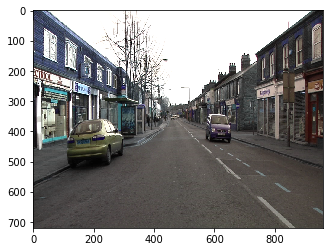

In [13]:
im_test = cv2.imread(str(test_f))
print(im_test.shape)
plt.imshow(im_test)

(720, 960, 3)
(720, 960, 3)


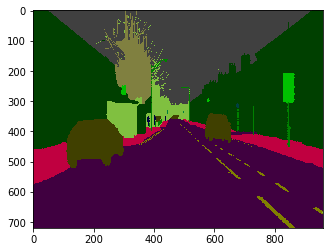

In [14]:
lbl_im_test = cv2.imread(str(test_lbl))
print(lbl_im_test.shape)
lbl_im_test = visualizeImage(color_map, lbl_im_test)
plt.imshow(lbl_im_test)

In [15]:
def adjust_image(img, mask):
    img = img / 255.
    mask = mask[:,:,0] if len(mask.shape) == 3 else mask[:,:,:,0]
    new_mask = np.zeros(mask.shape + (len(codes),))
    for i in range(len(codes)):
        new_mask[mask == i, i] = 1
    mask = new_mask
    return (img,mask)

In [16]:
def data_generator(path, input_path, output_path, size, batch_size=4,  seed=1):
    data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
    
    input_datagen = ImageDataGenerator(**data_gen_args)
    output_datagen = ImageDataGenerator(**data_gen_args)
    
    input_generator = input_datagen.flow_from_directory(
        directory=path, 
        classes = [input_path],
        batch_size=batch_size, 
        seed=seed, shuffle=True, 
        target_size=size,
        save_to_dir = './data/datagen/input/',
        class_mode=None, 
        color_mode='rgb'
    )
    
    output_generator = output_datagen.flow_from_directory(
        directory=path, 
        classes = [output_path],
        batch_size=batch_size, 
        seed=seed, shuffle=True,  
        target_size=size,
        save_to_dir = './data/datagen/output/',
        class_mode=None, 
        color_mode='grayscale'
    )
    
    
#     return itertools.izip(input_generator, output_generator)
    for (img,mask) in zip(input_generator, output_generator):
        img,mask = adjust_image(img,mask)
        yield (img,mask)

In [17]:
from tensorflow.keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Input, UpSampling2D
from tensorflow.keras.models import Model
# import numpy as np
from tensorflow.keras.layers import Concatenate

def unet_model(input_size = ()):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(drop4)
    
    conv5 = Conv2D(1024, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.2)(conv5)
    
    up6 = Conv2D(512, kernel_size=2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
#     merge6 = Add()([drop4, up6]) # merge6 = concatenate([drop4, up6], axis=3)
    merge6 = Concatenate(axis=3)([drop4, up6])
    conv6 = Conv2D(512, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, kernel_size=2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
#     merge7 = Add()([conv3, up7]) # merge7 = concatenate([conv3, up7], axis=3)
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, kernel_size=2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
#     merge8 = Add()([conv2, up8]) # merge8 = concatenate([conv2, up8], axis=3)
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, kernel_size=2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
#     merge9 = Add()([conv1, up9]) # merge9 = concatenate([conv1, up9], axis=3)
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv2D(32, kernel_size=3, activation='softmax', padding='same',)(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    return model
    

In [24]:
import numpy as np
bs = 4
size=(176, 240)
size_3d = (176, 240, 3)
step_epoch = np.ceil(len(fnames)//bs)
print(step_epoch)

175.0


In [25]:
model = unet_model(input_size=size_3d)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 176, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 176, 240, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 176, 240, 64) 36928       conv2d_59[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 88, 120, 64)  0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_61 

In [26]:
my_data_generator = data_generator(path, 'images','labels', size, bs)

In [27]:
%%time
from tensorflow.keras.callbacks import ModelCheckpoint
model = unet_model(input_size=size_3d)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_checkpoint = ModelCheckpoint('lesson3_unet.h5', monitor='loss',verbose=1, save_best_only=True)
fit = model.fit_generator(my_data_generator, steps_per_epoch=175, epochs=10, callbacks=[model_checkpoint],initial_epoch=0)

Found 701 images belonging to 1 classes.
Found 701 images belonging to 1 classes.
Epoch 1/10
174/175 [============================>.] - ETA: 0s - loss: 6.6837 - acc: 0.4579
Epoch 00001: loss improved from inf to 6.66826, saving model to unet_membrane.hdf5
175/175 [==============================] - 62s 354ms/step - loss: 6.6683 - acc: 0.4583
Epoch 2/10
174/175 [============================>.] - ETA: 0s - loss: 3.2831 - acc: 0.6399
Epoch 00002: loss improved from 6.66826 to 3.29100, saving model to unet_membrane.hdf5
175/175 [==============================] - 59s 335ms/step - loss: 3.2808 - acc: 0.6401
Epoch 3/10
174/175 [============================>.] - ETA: 0s - loss: 2.6799 - acc: 0.7093
Epoch 00003: loss improved from 3.29100 to 2.68686, saving model to unet_membrane.hdf5
175/175 [==============================] - 58s 330ms/step - loss: 2.6782 - acc: 0.7096
Epoch 4/10
174/175 [============================>.] - ETA: 0s - loss: 2.2761 - acc: 0.7426
Epoch 00004: loss improved from 2.68

# TEST

(176, 240)
(176, 240, 3)


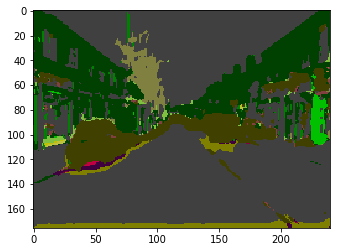

In [30]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test():
    im_test = load_img(test_f, grayscale=False, target_size=size)
    img2_array=img_to_array(im_test)
    img2_array = img2_array.reshape((1, ) + size_3d)

    pred_label = model.predict(img2_array, batch_size=1)
    
    pred_label = np.argmax(pred_label, axis=3).reshape(176,240)
    print(pred_label.shape)
    
    vizualize_im = visualizeImage(color_map, pred_label)
    plt.imshow(vizualize_im)
test()  

In [ ]:
fit = model.fit_generator(my_data_generator, steps_per_epoch=175, epochs=100, callbacks=[model_checkpoint])

Epoch 1/100
174/175 [============================>.] - ETA: 0s - loss: 0.9003 - acc: 0.8351
Epoch 00001: loss improved from 0.96575 to 0.90033, saving model to unet_membrane.hdf5
175/175 [==============================] - 56s 318ms/step - loss: 0.8991 - acc: 0.8352
Epoch 2/100
174/175 [============================>.] - ETA: 0s - loss: 0.8418 - acc: 0.8388
Epoch 00002: loss improved from 0.90033 to 0.84598, saving model to unet_membrane.hdf5
175/175 [==============================] - 56s 319ms/step - loss: 0.8432 - acc: 0.8387
Epoch 3/100
174/175 [============================>.] - ETA: 0s - loss: 0.8447 - acc: 0.8390
Epoch 00003: loss did not improve from 0.84598
175/175 [==============================] - 55s 312ms/step - loss: 0.8453 - acc: 0.8390
Epoch 4/100
174/175 [============================>.] - ETA: 0s - loss: 0.8614 - acc: 0.8386
Epoch 00004: loss did not improve from 0.84598
175/175 [==============================] - 55s 313ms/step - loss: 0.8606 - acc: 0.8387
Epoch 5/100
174/

(176, 240)
(176, 240, 3)


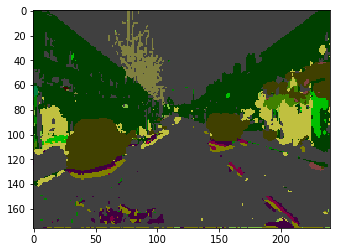

In [32]:
test()